# 🎮 Experiment 7: Support Vector Machine (SVM) on Video Game Sales

*Date: 20/02/2026*

---




## 🎯 Aim

To apply Support Vector Machine (SVM) on the Video Game Sales dataset and tune hyperparameters using Grid Search for optimal classification performance.

## 📖 Theory

Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks.  
It works by finding an optimal hyperplane that best separates different classes in the feature space.

Key advantages:
- Effective in high-dimensional spaces  
- Works well with clear margin of separation  
- Supports multiple kernel functions (linear, rbf, poly)

In this experiment, SVM is used to classify video games into sales categories.

## 📦 Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 📂 Loading Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("vgsales.csv")
df.head()

Saving vgsales.csv to vgsales.csv


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 🧹 Handling Missing Values

In [5]:
df = df.dropna()
print("Dataset shape after cleaning:", df.shape)

Dataset shape after cleaning: (16291, 11)


## 🏷️ Creating Sales Categories

We convert Global_Sales into three classes:

- Low Sales  
- Medium Sales  
- High Sales

In [6]:
q1 = df['Global_Sales'].quantile(0.33)
q2 = df['Global_Sales'].quantile(0.66)

def sales_cat(x):
    if x <= q1:
        return 0
    elif x <= q2:
        return 1
    else:
        return 2

df['Sales_Class'] = df['Global_Sales'].apply(sales_cat)

df['Sales_Class'].value_counts()

,count
Sales_Class,
0,5666
2,5490
1,5135


## 🎯 Feature Selection

In [7]:
X = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
y = df['Sales_Class']

print("Feature shape:", X.shape)

Feature shape: (16291, 4)


## ⚖️ Feature Scaling

SVM is sensitive to feature scale, so we standardize the data.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 🔀 Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 11403
Testing samples: 4888


## 🔍 Hyperparameter Tuning using Grid Search

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# ✅ create base model FIRST
svm = SVC(probability=True, random_state=42)

param_grid = {
    'C': [1, 10],
    'gamma': [0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(
    svm,
    param_grid,
    refit=True,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.9891256686836797


## 🤖 Training Best SVM Model

In [11]:
best_svm = grid_search.best_estimator_

y_pred_svm = best_svm.predict(X_test)
y_pred_proba_svm = best_svm.predict_proba(X_test)

print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_svm,
    target_names=['Low Sales','Medium Sales','High Sales']
))


Model Performance:
Accuracy: 0.9905891980360065

Classification Report:
              precision    recall  f1-score   support

   Low Sales       0.99      0.99      0.99      1691
Medium Sales       0.98      0.99      0.99      1554
  High Sales       1.00      1.00      1.00      1643

    accuracy                           0.99      4888
   macro avg       0.99      0.99      0.99      4888
weighted avg       0.99      0.99      0.99      4888



## 📊 Support Vector Information

In [12]:
print("Total support vectors:", best_svm.n_support_.sum())
print("Support vectors per class:", best_svm.n_support_)

Total support vectors: 1326
Support vectors per class: [466 662 198]


## 📉 PCA Visualization (2D Projection)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## 🎨 Kernel Comparison Visualization

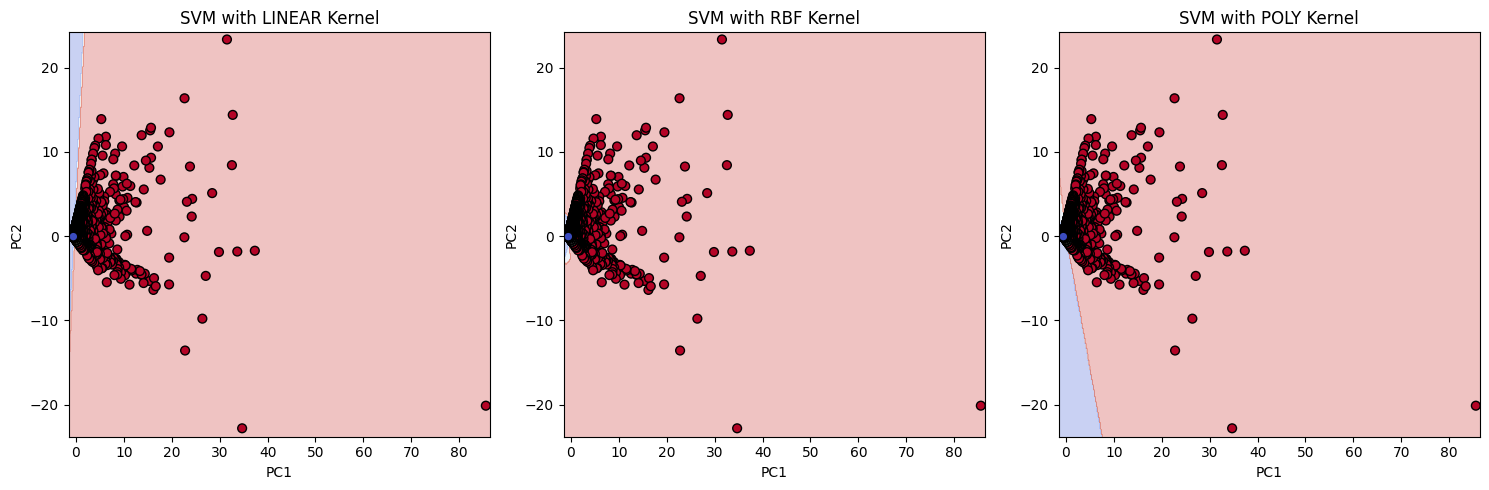

In [14]:
plt.figure(figsize=(15,5))

kernels = ['linear','rbf','poly']

for idx, kernel in enumerate(kernels, 1):
    plt.subplot(1,3,idx)

    svm_kernel = SVC(kernel=kernel, C=1, gamma='scale')
    svm_kernel.fit(X_pca[:,:2], y)

    h = 0.2
    x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
    y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1
    xx, yy = np.meshgrid(
        np.arange(x_min,x_max,h),
        np.arange(y_min,y_max,h)
    )

    Z = svm_kernel.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y,
                cmap='coolwarm', edgecolors='k', s=40)

    plt.title(f"SVM with {kernel.upper()} Kernel")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.tight_layout()
plt.show()

## ✅ Conclusion

Support Vector Machine successfully classified video games into different sales categories.  
Grid Search helped identify optimal hyperparameters, improving model performance and generalization.